# 线性回归的从 $0$ 实现

In [1]:
import numpy as np
import torch
import d2l.torch as d2l
import matplotlib.pyplot as plt

生成 : $y=Xw+b+\epsilon$ 的噪音 , $w$ 是 $\theta$

`normal(a,b,c)` : 生成 $mean$ 为 $a$ , $std$ 为 $b$ , $shape$ 为 $c$ 的数组

In [2]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2,-3.4])
true_b = torch.tensor([4.2])
features, lables = synthetic_data(true_w, true_b, 1000)

画出生成的数据，可以发现大致上是线性相关的，使用 $detach()$ 是因为有时候要先使用 $detach()$ 避免再次计算 $backward$ , pytorch 的一些版本需要 $detach$ 出来才能转成 $numpy$

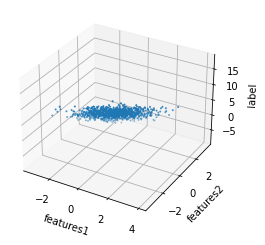

In [4]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('features1')
ax.set_ylabel('features2')
ax.set_zlabel('label')
ax.scatter(features[:,0].detach().numpy(),features[:,1].detach().numpy(),lables.detach().numpy(),s=1)

生成一个获取 $batch$ 的 $iterator$， $yield$ 的作用就是返回下面的值，然后每次进入函数再次进行上次 $yeild$ 之后的位置

In [5]:
def data_iter(batch_size, features, lables):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    """ 从0开始到num_exples, 每次跳batch_size这么大 """
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],lables[batch_indices]

初始化模型参数

In [6]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

构建一个隐式的方程

In [7]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

定义损失函数

In [8]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法，在更新的时候不需要计算梯度

在训练的时候是否要 $\div$ $batch\_size$ 或者说是否需要 $\div$ $n$ $m$这样一个问题，其实换在让 $learning$ $rate$ 变小也是可以处理的，当时就会让调参变得更加的复杂，$learning$ $rate$ 在每次换数据集的时候可能都需要进行一次调整

In [9]:
def sgd(Parameters, LearningRate, batch_size):
    with torch.no_grad():
        for param in Parameters:
            param -= LearningRate * param.grad / batch_size
            param.grad.zero_()

训练过程

In [10]:
learning_rate = 0.03
num_epochs = 5
net = linreg
loss = squared_loss
batch_size = 10

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features, lables):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w,b], learning_rate, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), lables)
        print(f'epoch {epoch +1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.045752
epoch 2, loss 0.000178
epoch 3, loss 0.000050
epoch 4, loss 0.000050
epoch 5, loss 0.000050


和真实数据进行比较

In [11]:
print(f'w 的估计误差 : {true_w - w.reshape(true_w.shape)}')
print(f'b 的估计误差 : {true_b - b.reshape(true_b.shape)}')

w 的估计误差 : tensor([-0.0003,  0.0005], grad_fn=<SubBackward0>)
b 的估计误差 : tensor([-0.0006], grad_fn=<SubBackward0>)
